## California housing prices

### Dataset
Dataset from the StatLib repository - based on the data from the 1990 California census

### Big Picture
Building a model of housing prices in the state - model should learn from this data and be able to predict the median housing price in any district, given all the other metrcis

### Setup

In [1]:
# Python ≥3.5 is required
import sys

# Scikit-learn ≥0.20 is required
import sklearn

# Common imports
import numpy as np
import os

# Plotting requirements
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Get the Data

#### Download the Data

In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("housing_data")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

##### Take a quick look at the data

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents one district.

There are 10 attributes : longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, ocean_proximity

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20640 instances in this dataset.

There are 207 missing values in total_bedrooms attribute.

All attributes are numerical except for the ocen_proximity field. The field type is object, and in this case it means it's text and based on the previosuly seen top 5 rows we can conclude it's a categorical attribute. We can check the categories of the field in the next section.

In [7]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


We can see the statistical summary of numerical attributes.

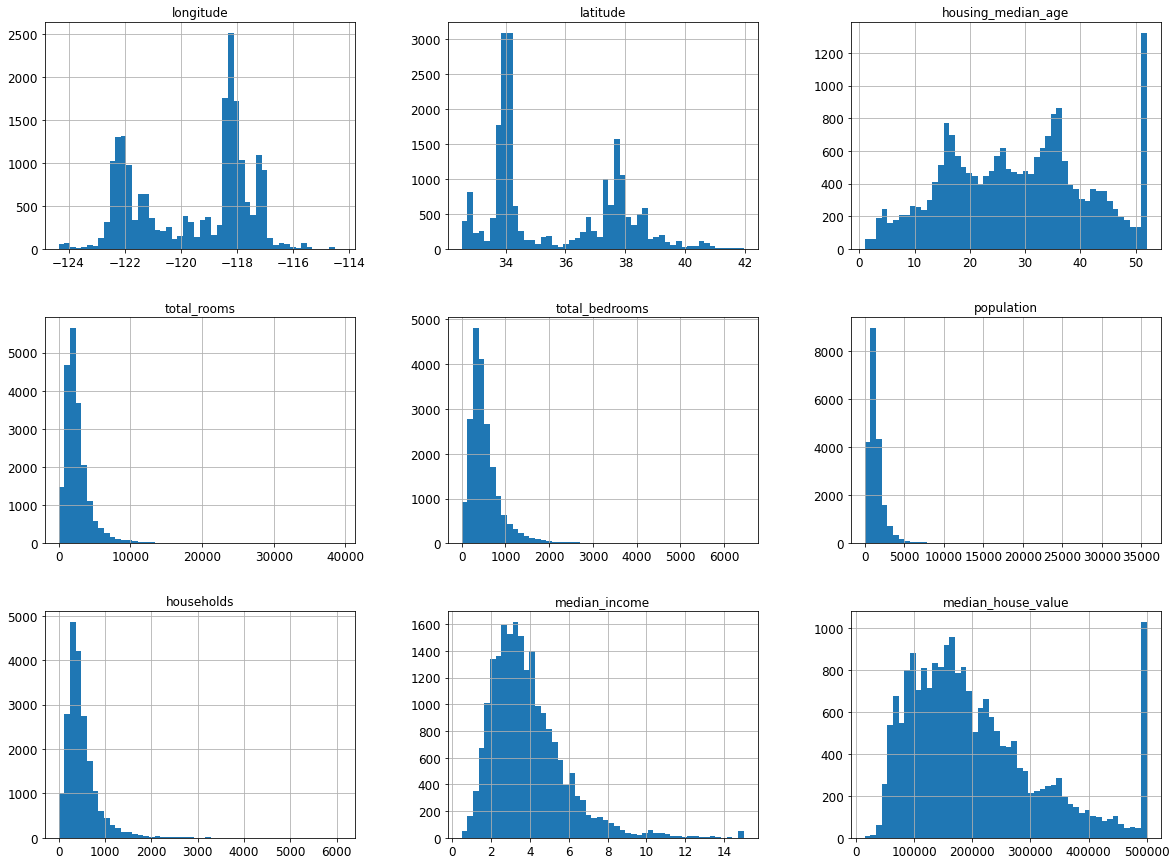

In [9]:
%matplotlib inline
housing.hist(bins=50, figsize=(20,15))
plt.show()

There are few things we might notice in these histograms:
1. The median income attribute is not expressed in US dollars. Data has been scaled and capped at 15 for higher median values and at 0.5 for lower median values. The numbers on the x axis represent roughly tens of thousands of dollars - 3 actually means income of about 30000 USD.
2. The housing median age and the median house value were also capped. The median house value might make some problems along the way if not addressed properly since it's our target attribute. The algorithms may learn that prices never go beyond that limit. If we need precise predictions even beyond 500000 USD, then there are two options:
    - collect proper labels for the districts whose labels were capped
    - remove those districts from the training set (and from the test set, so that the the system is not evaluiated poorly if it predicts values beyond 500000 USD
3. These attributes have very different scales.
4. Many histogram are tail-heavy: they extend much further to the right of the median than to the left. This may make it a bit harder for some ML algorithms to detect patterns. We will try transforming these attributes to have more bell-shaped distributions.

#### Create a test set

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [11]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


If we want to avoid a sampling bias - either the dataset needs to be large enough (especially relative to the number of attributes) or we need to do stratified sampling, dividing the population into homogeneous subgroups called strata. The right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population.

Since the median income attribute is a very important  attribute to predict median housing prices, we want to ensure there is no sampling bias and all values in the test set are represented in the same way as in our training set. As seen on the histogram, most median income values are clustered around 1.5 to 6 (15000 USD - 60000 USD), but some median incomes go far beyond 6. We create income category attribute with five categories labeled from 1-5.

In [12]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [13]:
housing['income_cat'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

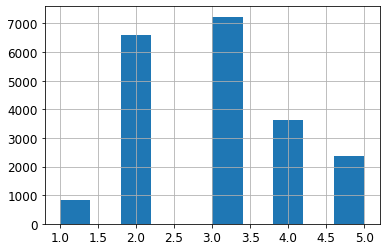

In [14]:
housing['income_cat'].hist()

Now we are ready to do stratified sampling based on the income category.

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Let's check if that worked as expected. We can look at the income category proportions in the test set.

In [16]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

Now we can compare it to the full dataset.

In [17]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

Removing the income_cat attribute so the data is back to its original state:

In [18]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Discover and Visualize the Data to Gain Insights

In [19]:
housing = strat_train_set.copy()

#### Visualizing geographical data

Since there is geographical information (latitude and longitude), it is a good idea to create a scatterplot of all districts to visualize the data.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

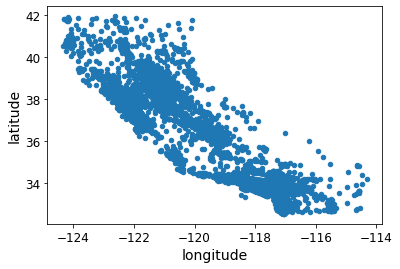

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

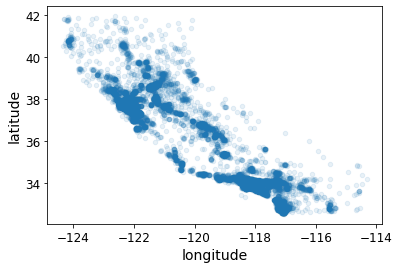

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Setting the alpha option to 0.1 makes it easier to visualize the places where there is a high density of data points.

Now let's look at the housing prices. The radius of each circle represents the district's population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high values).

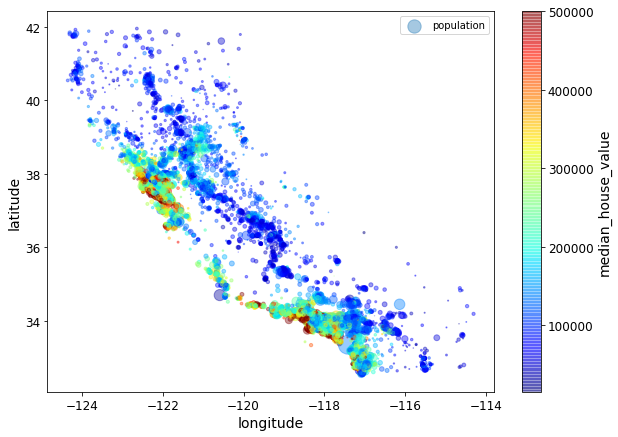

In [26]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

Even though the above scatterplot is easily interpretable, it's also useful adding a california map layer on the plot to make the displayed information full.

In [23]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/california.png', <http.client.HTTPMessage at 0x7f94a6cad990>)

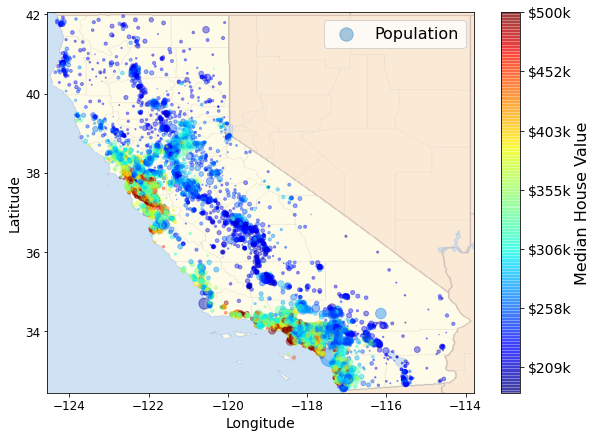

In [27]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

The image tells us that the housing prices are very much related to the location (warmer colors - hiher prices are closer to the ocean) and to the population density. A clustering algorithm should be useful for detecting the main cluster and for adding new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it's not a simple rule.

####  Looking for correlations

We can compute the standard correlation coefficient (Paerson's r) between every pair of attributes since the dataset is not too large.

In [28]:
corr_matrix = housing.corr()

Now let's look at how much each attribute correlates with the median house value:

In [30]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The median house value tends to go up when the median income goes up.

Another way to check for correlation between attributes is to use the pandas scatter_matrix() function, which plots every numerical attribute against every other numerical attribute. Here we focuse on few promising attributes that seem most correlated with the medain housing value (since plotting them all would result in 11x11=121 plots).

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

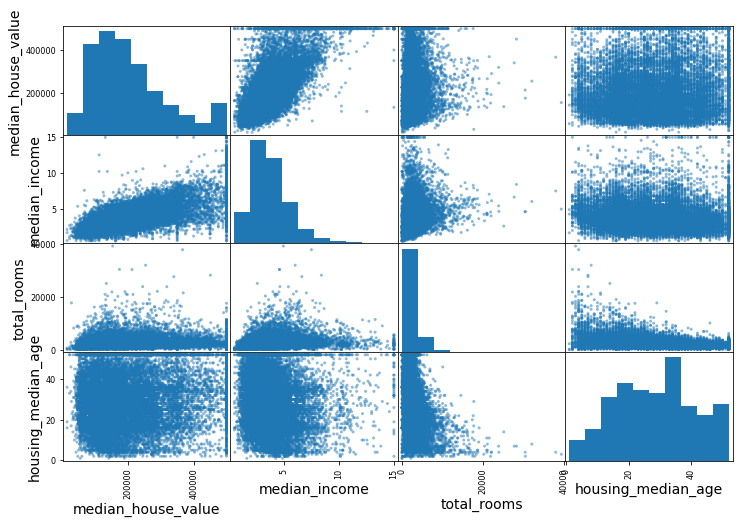

In [33]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

The main diagonal displays histograms of each attribute because plotting each variable against itself is not very useful. The most useful attribute to predict median house value is the median income, so let's focus on that.

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

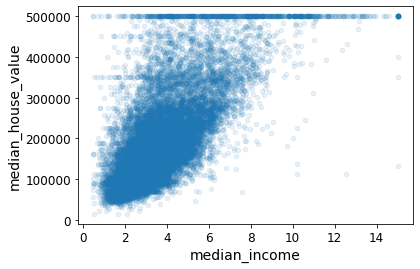

In [34]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

This plot reveals a few things. First, the correlation is indeed very strong; you can clearly see the upward trend, and the points are not too dispersed. Second, the price cap that we notices earlier is clearly visible as a horizontal line at 500 000 USD. But this plot reveals other less obvious straight line: a horizontal line around 450 000 and another around 350 000 USD. We may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

#### Experimenting with attribute combinations

One last thing to do before preparing the data for ML algorithm is to try out various attribute combinations.

In [36]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [37]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

The bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive.

In [38]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


### Prepare the data for ML algorithms

Let's start with cleaning the training dataset. First we separate predictors and the label, since we possibly don't want to do the same transformations on both.

In [39]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

#### Data cleaning

Most machine algorithms can't work with missing features, so let's create a few functions to take care of them. We saw earlier that the total_bedrooms attribute has some missing values, so let's fix this first. There are three options: 
1. Get rid of the corresponding districts
2. Get rid of the whole attribute
3. Set the values to some value (zero, the mean, the median,...)

Less than 2% of the data is missing which makes option 3 our best solution. We can use the Scikit-Learn and its SimpleImputer class.

In [40]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Only one thing is left to do and that is to remove the text attribute ocean_proximity since we can compute median only on numerical data:

In [42]:
housing_num = housing.select_dtypes(include=[np.number]) # or alternatively housing_num = housing.drop('ocean_proximity', axis=1)

We can now fit the imputer instance to the training data using the fit() method:

In [43]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

The imputer has simply computed the median for each attribute and stored the result in its statistics_ instance variable.

In [45]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [52]:
imputer.strategy

'median'

In [48]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [46]:
housing_num.median()

longitude             -118.5100
latitude                34.2600
housing_median_age      29.0000
total_rooms           2119.5000
total_bedrooms         433.0000
population            1164.0000
households             408.0000
median_income            3.5409
dtype: float64

Now we can use this 'trained' imputer to transform the training set by replacing missing values with the learned medians:

In [49]:
X = imputer.transform(housing_num)

The result is a plain NumPy array containing the transformed features. If we want to put it back into a pandas DataFrame:

In [51]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [53]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


#### Handling Text and Categorical Attributes

Now, let's preprocess the only categorical input feature, ocean_proximity:

In [60]:
housing_cat = housing.select_dtypes(include='object')
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


Most Ml algorithms work with numbers, so it's better to convert these categories from text to number. For this we can use Scikit-Learn's OrdinalEncoder class:

In [61]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [64]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two neerby values are more similar than two distant values. This may be fine in some cases (for ordered categories such as 'bad', 'average', 'good', 'excellent'), but in this particular case it is better to create one binary attribute per category: one attribute equal to 1 when the category is '<1H OCEAN' and 0 otherwise, another attribute equal to 1 when the category is 'INLAND' and 0 otherwise and so on. This is called one-hot encoding because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes calles dummy attributes. Scikit-Learn provides a ONeHotEncoder class to convert categorical values into one-hot vectors:

In [70]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

The output is a SciPy sparse matrix instead of NumPy array. This is very useful when you have categorical attributes with thousand of categories. After one-hot encoding, we get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. Using up tons of memory mostly to store 0s would be very wasteful, so instead a sparse matrix only sores the location of the nonzero elements.

#### Custom Transformers

Although Scikit-Learn provides many useful transformers, there is sometimes a need to write your own for tasks such as custom cleanup operations or combining specific attributes.

For example, here is a small transformer class that adds the combined attributes we discussed earlier:

In [73]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In this example the transformer has one hyperparameter, add_bedrooms_per_room, set to True by default. This hyperparameter will allow you to easily find out whether adding this attribute helps thge ML algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and save a lot of time).

Also, housing_extra_attribs is a NumPy array, so we've lost the column names. To recover a DataFrame, we run this:

In [71]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


#### Feature Scaling

ML algorithms generally don't perform well when the input numerical attributes have very different scales. This is the case for the housing data since the total number of rooms ranges from 6 to 39320 while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.

There are two common ways to get all atributes to have the same scale: min-max scaling and standardization.

Min-max scaling is the easiest: values are shifted and rescaled so that they end up ranging from 0 to 1. It is done by substracting the min value and dividing by the max minus the min.

Standardization is different: first it substracts the mean value (so standardized values have a zero mean), and  then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem to some algorithms. However, standardization is much less affected by outliers.

For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0-15 down to 0-0.15, whereas standardization would not be much affected.

Scikit-Learn provides a transformer for both techniques - MinMaxScaler and StandardScaler.

#### Transformation Pipelines

Now, let's build a pipeline for preprocessing the numerical attributes:

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [75]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column.

In [77]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = list(housing_cat)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [78]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

### Select and Train a Model

#### Training and evaluating on the training set

Let's first train a Linear Regression model:

In [80]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

Let's try it out on a few instances from the training set:

In [81]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


Compare against the actual values:

In [82]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [83]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

The predictions don't see quite accurate. Let's measure this regression model's RMSE on the whole training set using mean_squared_error() function:

In [85]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [86]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

This result is better than nothing, but clearly not a great score: most districts' median_housing_values range between 120000 and 265000 USD, so a typical prediction error of 68628 USD (or 49439 USD) is not very satisfying.

This is an example of model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good prediction, or that the model is not powerful enough. We could try and add more features, but first let's try a more complex model to see how it does.

Let's train a DecisionTreeRegressor. This is a powerful model, capable of finding complex nonlinear relationships in the data.

In [89]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

Now that the model is ztrained, let's evaluate it on the training set:

In [88]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

No error means that the model has badly overfit the data. Without using the cross-validation the model has seen all the data at once and learned all the patterns, so by evaluating the model on the same set of data we get this model behaviour.

One way to evaluate the Decision Tree model would be to use teh train_test_split() function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set.

A great alterntive is to use Scikit-Learn's K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an arary containing the 10 evaluation scores:

In [90]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [91]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


Now the Decision Tree doesn't look as good as it did earlier. In fact, it seems to perform worse than the Linear Regression model. Notice that the cross-validation  allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is with standard deviation. The Decison Tree has a score of approximately 71407 USD +/-2439 USD.

Let's compute the same scores for the Linear Regression model just to be sure:

In [92]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983493


That's right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

Let's try one last model now: RandomForestRegressor. Random Forests work by training many Decision Trees on random subsets of the features, the averaging out their predicitons.

In [93]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [94]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [96]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


This is much better score. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it (regularize it), or get a lot more training data.

Also, the right way would be to try out many other models from various categories of ML algorithms (SVMs with different kerenels, neural network,...) without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (2 to 5) promising models.

Good idea is to save every model we experimented with so that we can easily get back to any model we want. Saving the model should be done with both the hyperparameters and the trained paramneters, as well as the cross-validation scores and perhaps the actual predictions. This allows for easier comparison of scores across model types, and compare the types of errors they make.

In [98]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

### Fine-Tuning the model

#### Grid Search

One option would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore all the combinations.

Instead, let's use the GridSearchCV. All we need to do is tell it which hyperparameters we waqnt to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values.

In [99]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

Let's see what is the best combination of parameters:

In [100]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [101]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

The evaluation scores of each hyperparameter combination tested during the grid search:

In [102]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

The best solution is get by setting the max_features hyperparameter to 8 and the n_estimators hyperparameter to 30. The RMSE score for this combination is 49682 which is better than the score we got earlier using the default hyperparameter values (which was 50182).

#### Randomized search

Another option is to use RandomizedSearchCV. This class can be used in the same way as the GridSearchCV class, but instead of trying out all possibllle combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has 2 main benefits:
1. If we let it run for 1000 iterations this approcah will explore 1000 different values for each hyperparameter at every iteration (instead of just a few values per hyperparameter with the grid search approach).
2. Simply by setting the number of iterations , you have more control over the computing budget you want to allocate to hyperparameter search.

The grid search is still a valid option when you're exploring relatively few combinations like we did in the previous part.

In [105]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f948d3a2e10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f948c260610>},
                   random_state=42, scoring='neg_mean_squared_error')

In [106]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


We can see that the randomized search showed what we suspected after grid search: n_number hyperparameter was producing better results with higher values. The lowest RMSE is 49150 with the combination of max_features set to 7 and n_estimators to 180.

#### Analyzing the best models and their errors

Let's inspect our current best model, the RandomForestregressor. It can indicate the relative importance of each attribute for making accurate predicitons:

In [111]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [112]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([7.24699052e-02, 6.38080322e-02, 4.27504395e-02, 1.65343807e-02,
       1.56100762e-02, 1.60929106e-02, 1.52149598e-02, 3.45178404e-01,
       5.74445360e-02, 1.08468449e-01, 7.05907498e-02, 8.77441303e-03,
       1.60563229e-01, 6.10403994e-05, 3.08961266e-03, 3.34886200e-03])

Let's display these importance scores next to their corresponding attribute names:

In [113]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3451784043801197, 'median_income'),
 (0.1605632289158767, 'INLAND'),
 (0.10846844860879654, 'pop_per_hhold'),
 (0.07246990515559049, 'longitude'),
 (0.07059074984842853, 'bedrooms_per_room'),
 (0.06380803224443841, 'latitude'),
 (0.057444535971841064, 'rooms_per_hhold'),
 (0.04275043945662488, 'housing_median_age'),
 (0.01653438073955306, 'total_rooms'),
 (0.016092910597195798, 'population'),
 (0.015610076150868492, 'total_bedrooms'),
 (0.015214959838627942, 'households'),
 (0.008774413032023276, '<1H OCEAN'),
 (0.003348861998751043, 'NEAR OCEAN'),
 (0.0030896126618977565, 'NEAR BAY'),
 (6.104039936629334e-05, 'ISLAND')]

With this information, we may want to try dropping some of the less valuable and useful features (e.g., apparently only one ocean_proximity category is really useful, so an option is to try and drop the others

#### Evaluating the system on the test set

We need to remeber to run our full_pipeline to transform the test_set as we did our train_set. We only call the transform() and not the fit_transform() since we don't want to fit the test set and evaluate the final model on the test_set.

In [114]:
final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [116]:
final_rmse

46910.92117024934

We want to compute the 95% confidence interval for the generalization error to have some precision from our RMSE estimate:

In [117]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([44945.41068188, 48797.32686039])